# Exploratory Data Analysis

__Group: Alysson Espíndola de Sá Silveira, Rener de Souza Oliveira, Yuri Luis Faria Silva__

In [19]:
# !apt-get install libgeos-3.5.0
# !apt-get install libgeos-dev
# !pip install https://github.com/matplotlib/basemap/archive/master.zip
# !pip install pyproj==1.9.6
# !pip install netCDF4
# !pip install jinja2
# !pip install geopy
# !pip install xarray
# !pip install networkx
# !pip install requests
# !pip install cartopy
# !pip install tropycal
#Uncomment the above lines and execute this cell; then go to "Runtime"->"Restart Runtime".

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
from mpl_toolkits.basemap import Basemap,shiftgrid
import pandas as pd
import netCDF4 as nc

## 1 - Missing Data - netCDF4

This part of our data is in .nc file extension, which stands for netCDF4. It's widely used in climatology and has python support for reading it.

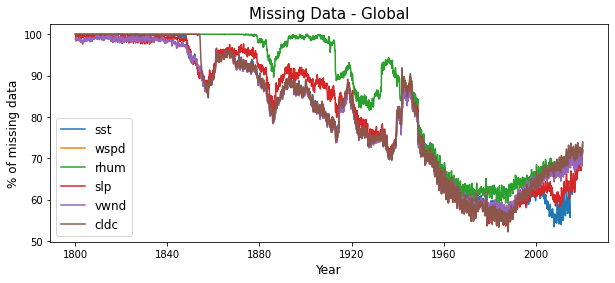

<class 'numpy.ma.core.MaskedArray'>


In [2]:
sst_mean = nc.Dataset('Datasets/sst.mean.nc','r')
rhum_mean = nc.Dataset('Datasets/rhum.mean.nc','r')
wspd_mean = nc.Dataset('Datasets/wspd.mean.nc','r')
slp_mean = nc.Dataset('Datasets/slp.mean.nc','r')
vwnd_mean = nc.Dataset('Datasets/vwnd.mean.nc','r')
cldc_mean = nc.Dataset("Datasets/cldc.mean.nc",'r')

lats = sst_mean.variables['lat'][:]
lons = sst_mean.variables['lon'][:]
time = sst_mean.variables['time'][:]

sst = sst_mean.variables['sst'][:,:,:]
rhum = rhum_mean.variables['rhum'][:,:,:]
wspd = wspd_mean.variables['wspd'][:,:,:]
slp = slp_mean.variables['slp'][:,:,:]
vwnd = vwnd_mean.variables['vwnd'][:,:,:]
cldc = cldc_mean.variables['cldc'][:,:,:]

sst_mean.close()
wspd_mean.close()
rhum_mean.close()
slp_mean.close()
vwnd_mean.close()
cldc_mean.close()

period = pd.date_range(start = "1800-01-01",end = "2020-07-01", freq = "MS").to_pydatetime().tolist()

def get_missing(data:list,labels:list)->dict:
    missing={}
    lenght = data[0].shape[0]
    for j,item in enumerate(data):
        missing[labels[j]] = []
        for i in range(lenght):
            missing[labels[j]].append(100*np.sum(item[i].mask)/item[i].data.size)
    return missing

missing = get_missing([sst,wspd,rhum,slp,vwnd,cldc],['sst','wspd','rhum','slp','vwnd','cldc'])

fig,ax = plt.subplots(1,1,figsize=(10,4))

ax.set_title("Missing Data - Global",fontsize=15)
ax.set_xlabel("Year",fontsize=12)
ax.set_ylabel("% of missing data",fontsize=12)
for key,value in missing.items():
    ax.plot(period,missing[key],label=key)
ax.legend(loc='best',fontsize=12);
fig.savefig('missing.png')
plt.show()

print(type(sst))

__Legend:__

- sst: Sea Surface Temperature
- wspd: Scalar Wind Speed
- rhum: Relative Humidity
- slp: Sea Level Pressure
- vwnd: V-wind component
- cldc: Cloudiness

Since continents represent approximately $29,1\%$ of earth surface and the data cover just oceans, The continents are filled with missing values. So, naturally, this percentage is the lower bound of missing data.


Note that the data types are "numpy.ma.core.MaskedArray" which has an attribute "mask", which is an indicator variable of missingness; That's gonna help us deal with it.

As we can see in the above plot, we have decades with missingness levels above 90%. Soon, we're gonna analyze focusing on Pacific and North Atlantic, which is our study area.

(array([ 3.,  3., 12., 20., 30., 36., 32., 23., 30.,  6.]),
 array([-0.30999756,  0.36400145,  1.0380005 ,  1.7119995 ,  2.3859985 ,
         3.0599976 ,  3.7339966 ,  4.4079957 ,  5.0819945 ,  5.755994  ,
         6.4299927 ], dtype=float32),
 <a list of 10 Patch objects>)

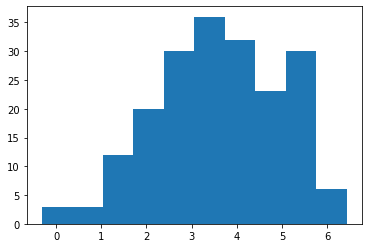

In [4]:
sst_mean = nc.Dataset('Datasets/sst.mean.nc','r')
x = sst_mean['sst'][:]
plt.hist(x[:,70, 40][x[:,70, 40].data<20000]) #testes com masked array

In [5]:
x.shape

(2647, 90, 180)

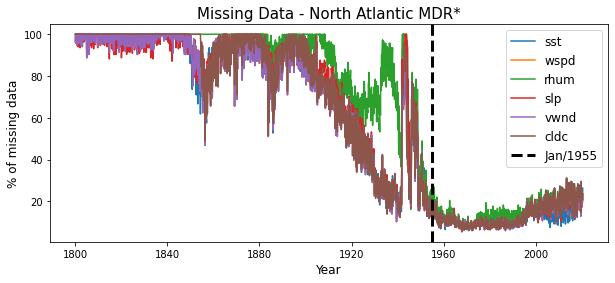

In [3]:
sst_at = sst[:,34:40,51:82] #10°-20°N, 80°-20°W
wspd_at = wspd[:,34:40,51:82]
rhum_at = rhum[:,34:40,51:82]
slp_at = slp[:,34:40,51:82]
vwnd_at = vwnd[:,34:40,51:82]
cldc_at = cldc[:,34:40,51:82]

# sst_pac = sst[:,14:45,0:41] #0°-60°N, 100°W-180°W
# wspd_pac = wspd[:,14:45,0:41]
# rhum_pac = rhum[:,14:45,0:41]

missing_at = get_missing([sst_at,wspd_at,rhum_at,slp_at,vwnd_at,cldc_at],['sst_at','wspd_at','rhum_at','slp_at','vwnd_at','cldc_at'])
# missing_pac = get_missing([sst_pac,wspd_pac,rhum_pac],['sst_pac','wspd_pac','rhum_pac'])

# fig,(ax,ax1) = plt.subplots(2,1,figsize=(10,8))
fig,ax = plt.subplots(1,1,figsize=(10,4))
ax.set_title("Missing Data - North Atlantic MDR*",fontsize=15)
ax.set_xlabel("Year",fontsize=12)
ax.set_ylabel("% of missing data",fontsize=12)
for key,value in missing_at.items():
    ax.plot(period,missing_at[key],label=key[0:-3])
plt.axvline(x=period[1860],label = "Jan/1955",color = 'black', lw=3,ls='--')

ax.legend(loc='best',fontsize=12);
fig.savefig('missing_mdr.png')

\*MDR stands for _Main Development Region_ which refers to the rectangle 10°-20°N, 80°-20°W.

We can see that after the decade 1950-1960, we have more a more complete dataset in our study region. So, to understand the relation of the variables, we're gonna work starting this decade.

But, nothing keeps us from working with older data, since values don't vary a lot when it's close; If we wanted to work with long-term trends we could cut the data starting from 1920, and just apply the mean, even with $\approx70$% of missing data. that's because we have an indicator array, which can help with modeling. Also, this percentage is a little lower because of the continental area in the MDR cut considered. 

Below, we have an example of the distribution of SST data in January 1955.

## 2 - Visualization

In [4]:
#Transforms longitude ranges from [0,360] para [-180,180] --> useful for plot

sst[:],lonsn = shiftgrid(180,sst[:],lons,start=False)
wspd[:],lonsn = shiftgrid(180,wspd[:],lons,start=False)
# shum[:],lonsn = shiftgrid(180,shum[:],lons,start=False)
rhum[:],lonsn = shiftgrid(180,rhum[:],lons,start=False)
lons = lonsn

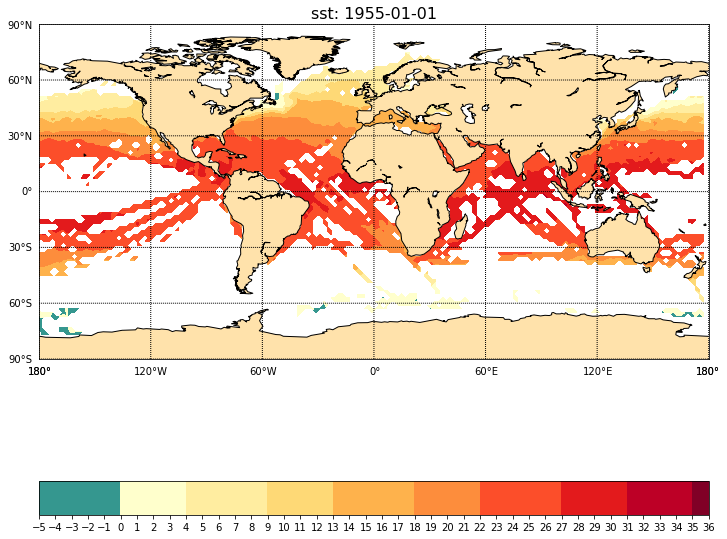

In [5]:
#Reference: https://annefou.github.io/metos_python/04-plotting/
time_index = 1860

fig = plt.figure(figsize=[12,15])
ax = fig.add_subplot(1, 1, 1)
ax.set_title("sst: {}".format(period[time_index].date()),fontsize=16)
map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c', ax=ax)
map.drawcoastlines()
map.fillcontinents(color='#ffe2ab')

map.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
map.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])


llons, llats = np.meshgrid(lons, lats)
x,y = map(llons,llats)


cmap = c.ListedColormap(['#35978f','#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c',
                        '#fc4e2a','#e31a1c','#bd0026','#800026'])
bounds=list(np.arange(-5,37,1))
# bounds=list(np.arange(10,100,5))
norm = c.BoundaryNorm(bounds, ncolors=cmap.N)

cs = map.contourf(x,y,sst[time_index], cmap=cmap, norm=norm, levels=bounds)
fig.colorbar(cs, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, ax=ax, orientation='horizontal');

A good way to visualize this data is with animation, but the above plot gives us a very good glimpse of what kind of data we're working on.

In [6]:
print(period[1860]) # -- Janeiro de 1955
def get_mean(data):
    size = data.shape[0]
    new = np.array([])
    for i in range(size):
        new = np.append(new,np.mean(data[i,:,:]))
    return new

data_at = pd.DataFrame(get_mean(sst_at[1860:,:,:]),columns =["sst"])
period_df = pd.DataFrame(period[1860:],columns = ["Date"])
period_df['Year']=period_df.Date.map(lambda x: x.year)
period_df['Month']=period_df.Date.map(lambda x: x.month)
data_at['rhum'] = pd.DataFrame(get_mean(rhum_at[1860:,:,:]),columns =["rhum"])
data_at['slp'] = pd.DataFrame(get_mean(slp_at[1860:,:,:]),columns =["slp"])
data_at['vwnd'] = pd.DataFrame(get_mean(vwnd_at[1860:,:,:]),columns =["vwnd"])
data_at['cldc'] = pd.DataFrame(get_mean(cldc_at[1860:,:,:]),columns =["cldc"])

atlantic_mdr = pd.concat([period_df,data_at],axis=1)

cum_sum = {}
for i in range(1,13):
    cum_sum[i]=0
k=0 #year count
for i in range(0,atlantic_mdr.shape[0]-12):
    month = atlantic_mdr.iloc[i,:].Month
    if month%12==1:
        k+=1
    cum_sum[month]+=atlantic_mdr.iloc[i,3]
    atlantic_mdr.loc[atlantic_mdr.index[i],'sst_anomaly'] = atlantic_mdr.iloc[i,3]-cum_sum[month]/k
atlantic_mdr.drop('sst_anomaly',axis=1).to_csv('atlantic_mdr.csv',index=False)
atlantic_mdr.iloc[12:24,:]

1955-01-01 00:00:00


,Date,Year,Month,sst,rhum,slp,vwnd,cldc,sst_anomaly
12,1956-01-01,1956,1,25.726978,77.001086,1012.134727,-3.460925,4.358905,0.245448
13,1956-02-01,1956,2,25.037457,75.518193,1012.072622,-2.784498,4.078091,0.216897
14,1956-03-01,1956,3,24.872203,77.678922,1012.939417,-2.312943,3.991988,0.188097
15,1956-04-01,1956,4,25.196404,78.834415,1011.260417,-0.964061,4.113334,0.197252
16,1956-05-01,1956,5,25.468135,80.557906,1010.785056,0.677937,4.153167,-0.026809
17,1956-06-01,1956,6,25.919226,81.541850,1010.267340,0.945335,4.144269,-0.106740
18,1956-07-01,1956,7,26.460352,81.545238,1008.652439,2.379446,5.090152,-0.192548
19,1956-08-01,1956,8,27.155499,80.754959,1008.356269,2.149878,5.416736,-0.224637
20,1956-09-01,1956,9,27.527199,81.055189,1008.395965,1.700319,5.332243,-0.270943
21,1956-10-01,1956,10,27.606902,80.031473,1010.252752,-1.486287,4.657819,-0.188678


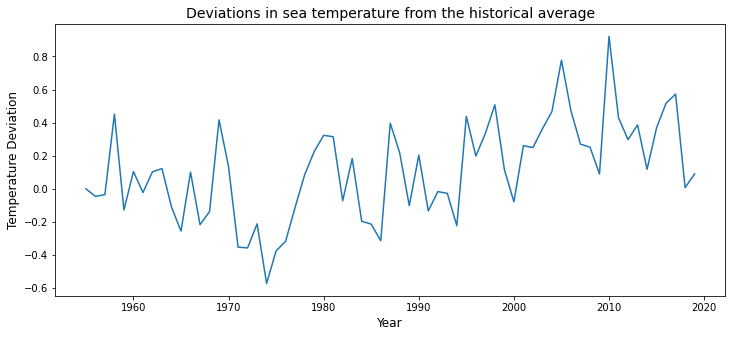

In [8]:
fig,ax = plt.subplots(1,1,figsize=(12,5))

ax.plot(np.arange(1955,2021,1),atlantic_mdr.groupby(['Year']).agg({'sst_anomaly':np.mean})['sst_anomaly'])
ax.set_title("Deviations in sea temperature from the historical average",fontsize=14)
ax.set_xlabel("Year",fontsize=12)
ax.set_ylabel("Temperature Deviation",fontsize=12);


In [9]:
corr = atlantic_mdr.corr()
corr.style.background_gradient(cmap='coolwarm')

,Year,Month,sst,rhum,slp,vwnd,cldc,sst_anomaly
Year,1.000000,-0.011135,0.149470,-0.053989,0.054166,-0.021315,0.199310,0.428715
Month,-0.011135,1.000000,0.760556,0.392721,-0.427661,0.153755,0.376915,0.030242
sst,0.149470,0.760556,1.000000,0.644627,-0.622876,0.432286,0.555543,0.375395
rhum,-0.053989,0.392721,0.644627,1.000000,-0.770796,0.805437,0.335448,0.083454
slp,0.054166,-0.427661,-0.622876,-0.770796,1.000000,-0.812725,-0.559845,0.071093
vwnd,-0.021315,0.153755,0.432286,0.805437,-0.812725,1.000000,0.247360,0.055257
cldc,0.199310,0.376915,0.555543,0.335448,-0.559845,0.247360,1.000000,0.042846
sst_anomaly,0.428715,0.030242,0.375395,0.083454,0.071093,0.055257,0.042846,1.000000


## 3 - The Hurricane Dataset

In [4]:
df = pd.read_csv('Datasets/atlantic.csv')
df2 = pd.read_csv('Datasets/pacific.csv')

# Formatting latitude and longitude
df.Date = pd.to_datetime(df.Date, format="%Y%m%d")
df["month"] = df["Date"].apply(lambda x: x.month)
df["year"] = df["Date"].apply(lambda x: x.year)
df.Latitude = df.Latitude.apply(lambda x: -float(x.rstrip("S")) if x.endswith("S") else float(x.rstrip("N")))
df.Longitude = df.Longitude.apply(lambda x: -float(x.rstrip("W")) if x.endswith("W") else float(x.rstrip("E")))

df2.Date = pd.to_datetime(df2.Date, format="%Y%m%d")
df2["month"] = df2["Date"].apply(lambda x: x.month)
df2["year"] = df2["Date"].apply(lambda x: x.year)
df2.Latitude = df2.Latitude.apply(lambda x: -float(x.rstrip("S")) if x.endswith("S") else float(x.rstrip("N")))
df2.Longitude = df2.Longitude.apply(lambda x: -float(x.rstrip("W")) if x.endswith("W") else float(x.rstrip("E")))


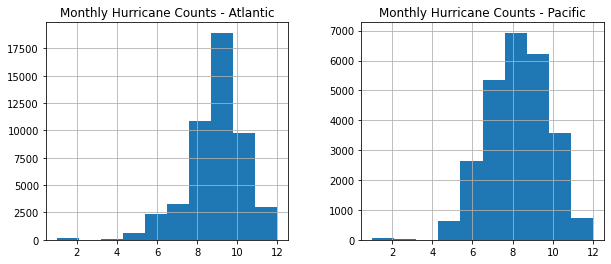

In [5]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
df.hist('month', ax=axs[0])
# plt.hist(df.month, ax=axs[0])
axs[0].set_title("Monthly Hurricane Counts - Atlantic") #tepo
df2.hist('month', ax=axs[1])
axs[1].set_title("Monthly Hurricane Counts - Pacific");

In [6]:
#Formatting text entries

df['Name'] = df['Name'].apply(lambda x: x.strip())
df['Event'] = df['Event'].apply(lambda x: x.strip())
df['Status'] = df['Status'].apply(lambda x: x.strip())

df2['Name'] = df2['Name'].apply(lambda x: x.strip())
df2['Event'] = df2['Event'].apply(lambda x: x.strip())
df2['Status'] = df2['Status'].apply(lambda x: x.strip())

In [14]:
df.to_csv("Datasets/atlantic_new.csv",index=False)
df2.to_csv("Datasets/pacific_new.csv",index=False)

In [10]:
df.dtypes

ID                          object
Name                        object
Date                datetime64[ns]
Time                         int64
Event                       object
Status                      object
Latitude                   float64
Longitude                  float64
Maximum Wind                 int64
Minimum Pressure             int64
Low Wind NE                  int64
Low Wind SE                  int64
Low Wind SW                  int64
Low Wind NW                  int64
Moderate Wind NE             int64
Moderate Wind SE             int64
Moderate Wind SW             int64
Moderate Wind NW             int64
High Wind NE                 int64
High Wind SE                 int64
High Wind SW                 int64
High Wind NW                 int64
month                        int64
year                         int64
dtype: object

In [7]:
df[df.year==2011].sort_values(by='Maximum Wind',ascending=0)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,month,year
47316,AL162011,OPHELIA,2011-10-02,0,,HU,32.8,-62.5,120,940,...,60,60,40,40,30,30,20,20,10,2011
47154,AL122011,KATIA,2011-09-06,0,,HU,25.6,-64.0,120,942,...,80,70,60,70,50,50,40,50,9,2011
47155,AL122011,KATIA,2011-09-06,600,,HU,26.2,-64.8,115,946,...,80,70,60,70,50,50,40,50,9,2011
47315,AL162011,OPHELIA,2011-10-01,1800,,HU,30.7,-62.9,110,946,...,60,60,40,40,30,30,20,20,10,2011
47153,AL122011,KATIA,2011-09-05,1800,,HU,24.8,-63.4,110,946,...,80,70,60,70,50,50,40,50,9,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47201,AL132011,LEE,2011-09-06,600,,EX,33.4,-85.3,20,997,...,0,0,0,0,0,0,0,0,9,2011
47119,AL122011,KATIA,2011-08-28,600,,LO,9.4,-20.3,20,1011,...,0,0,0,0,0,0,0,0,8,2011
47118,AL122011,KATIA,2011-08-28,0,,LO,9.5,-19.0,20,1012,...,0,0,0,0,0,0,0,0,8,2011
47202,AL132011,LEE,2011-09-06,1200,,EX,34.2,-85.1,15,1000,...,0,0,0,0,0,0,0,0,9,2011


In [2]:
# from cartopy import features.Border
import tropycal.tracks as tracks
hurdat = tracks.TrackDataset(basin='north_atlantic')

--> Starting to read in HURDAT2 data
--> Completed reading in HURDAT2 data (5.41 seconds)


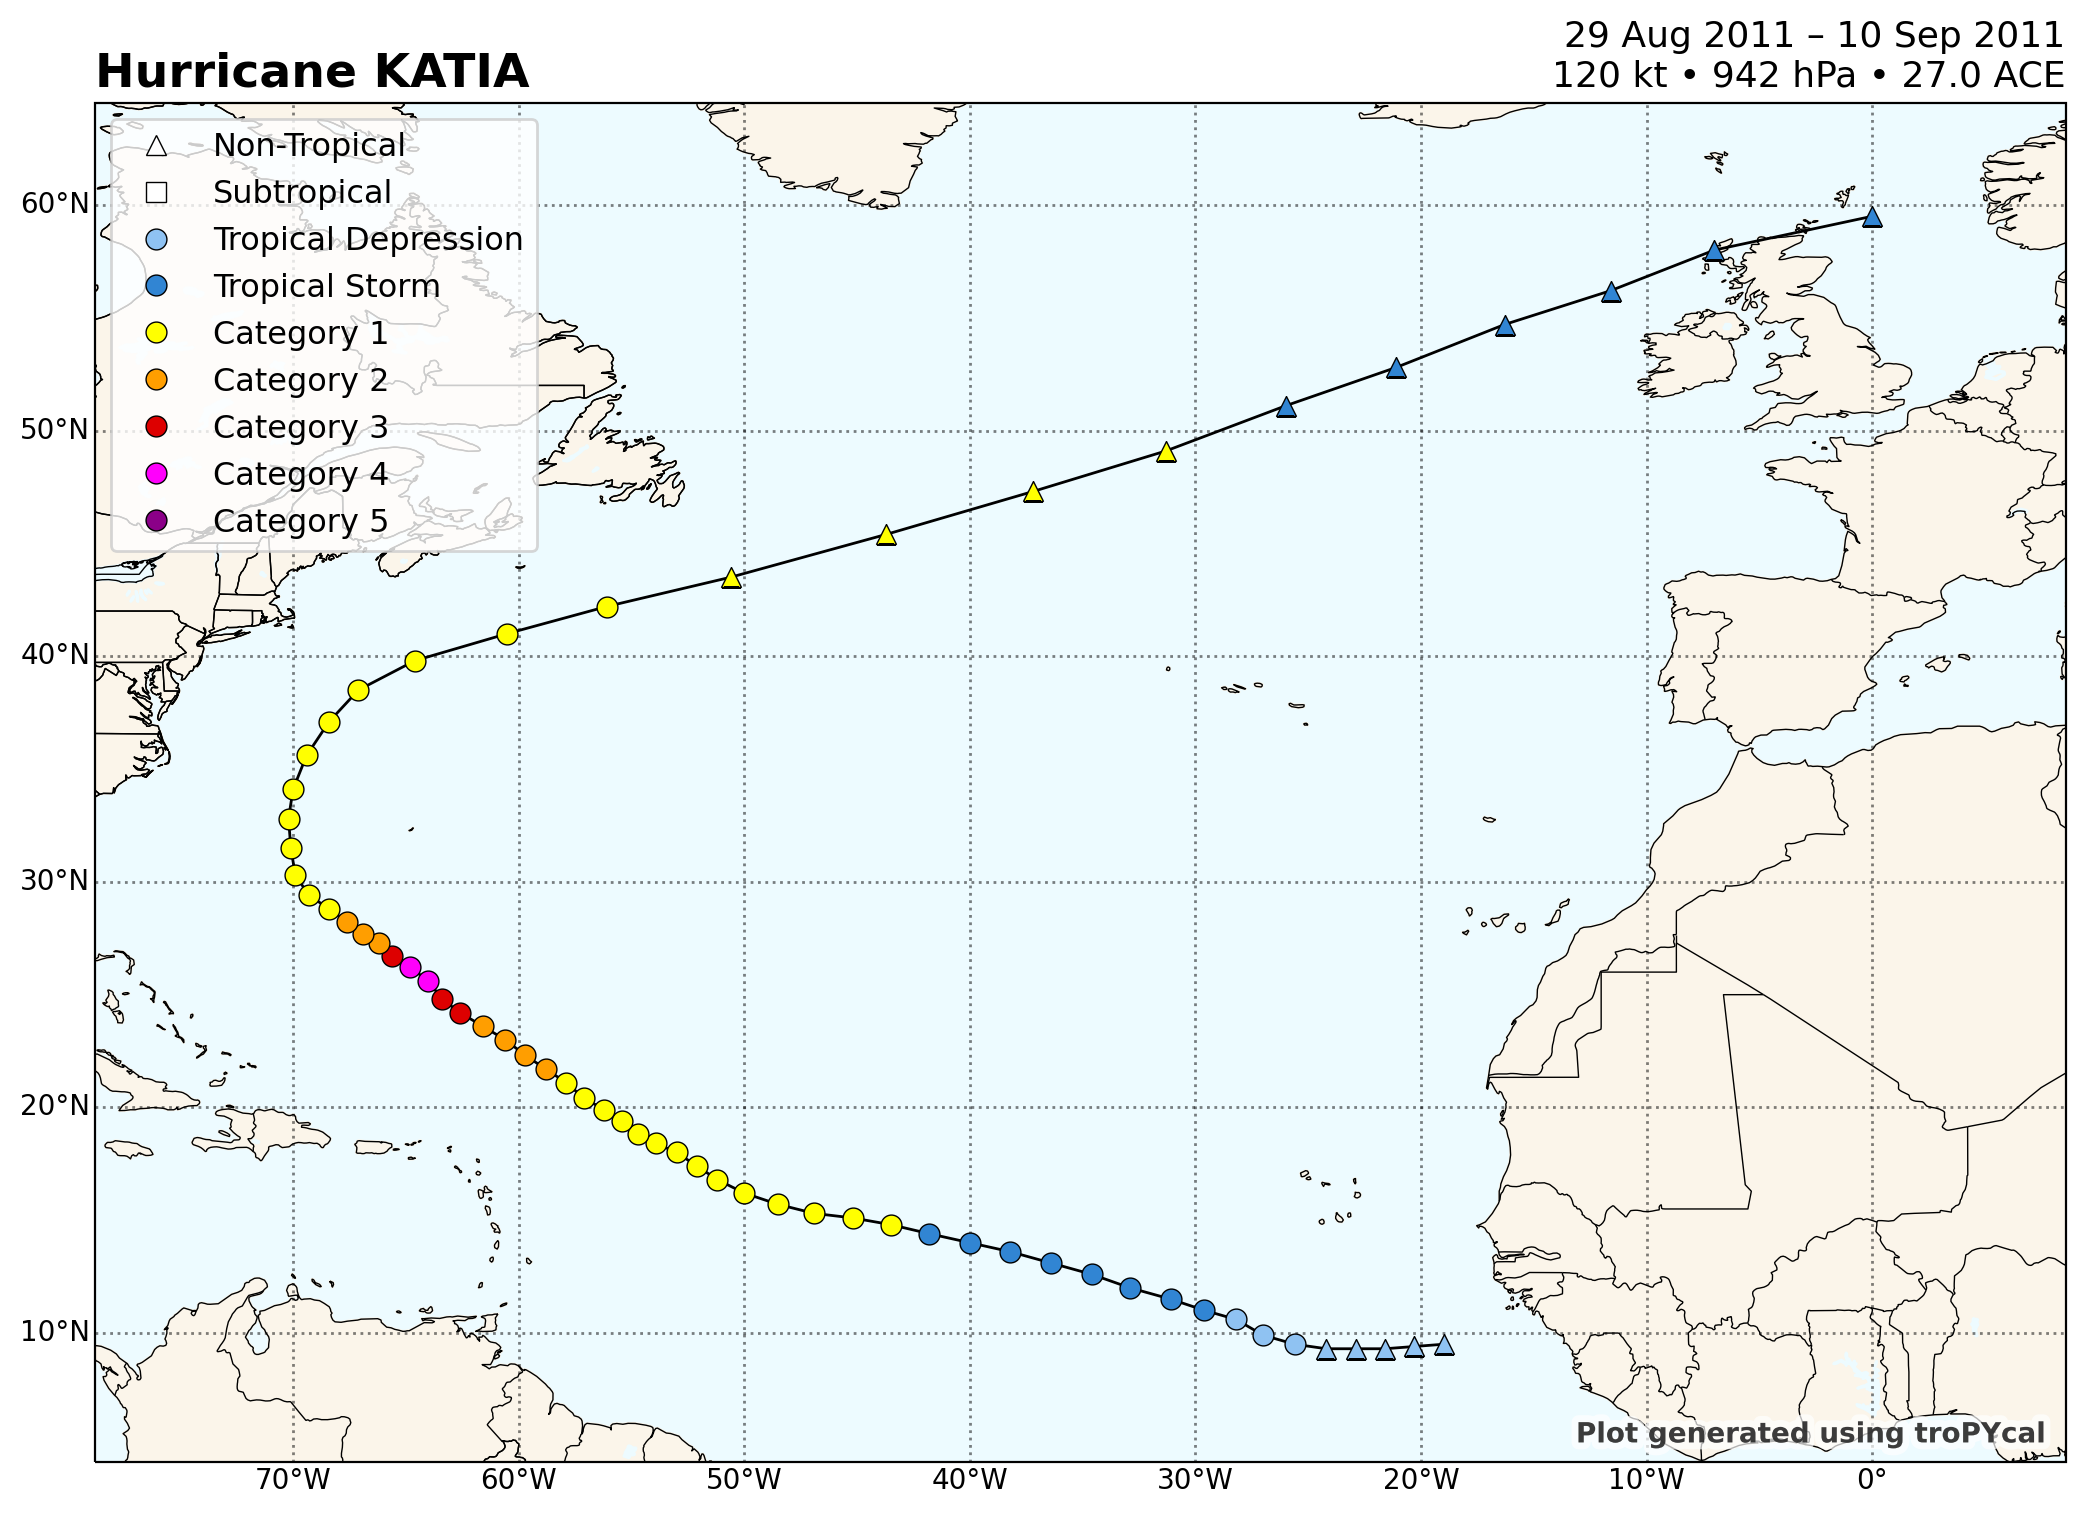

In [10]:
import cartopy.crs as ccrs
katia = hurdat.get_storm(('katia',2011))
ophelia =  hurdat.get_storm(('ophelia',2011))
katia.plot()

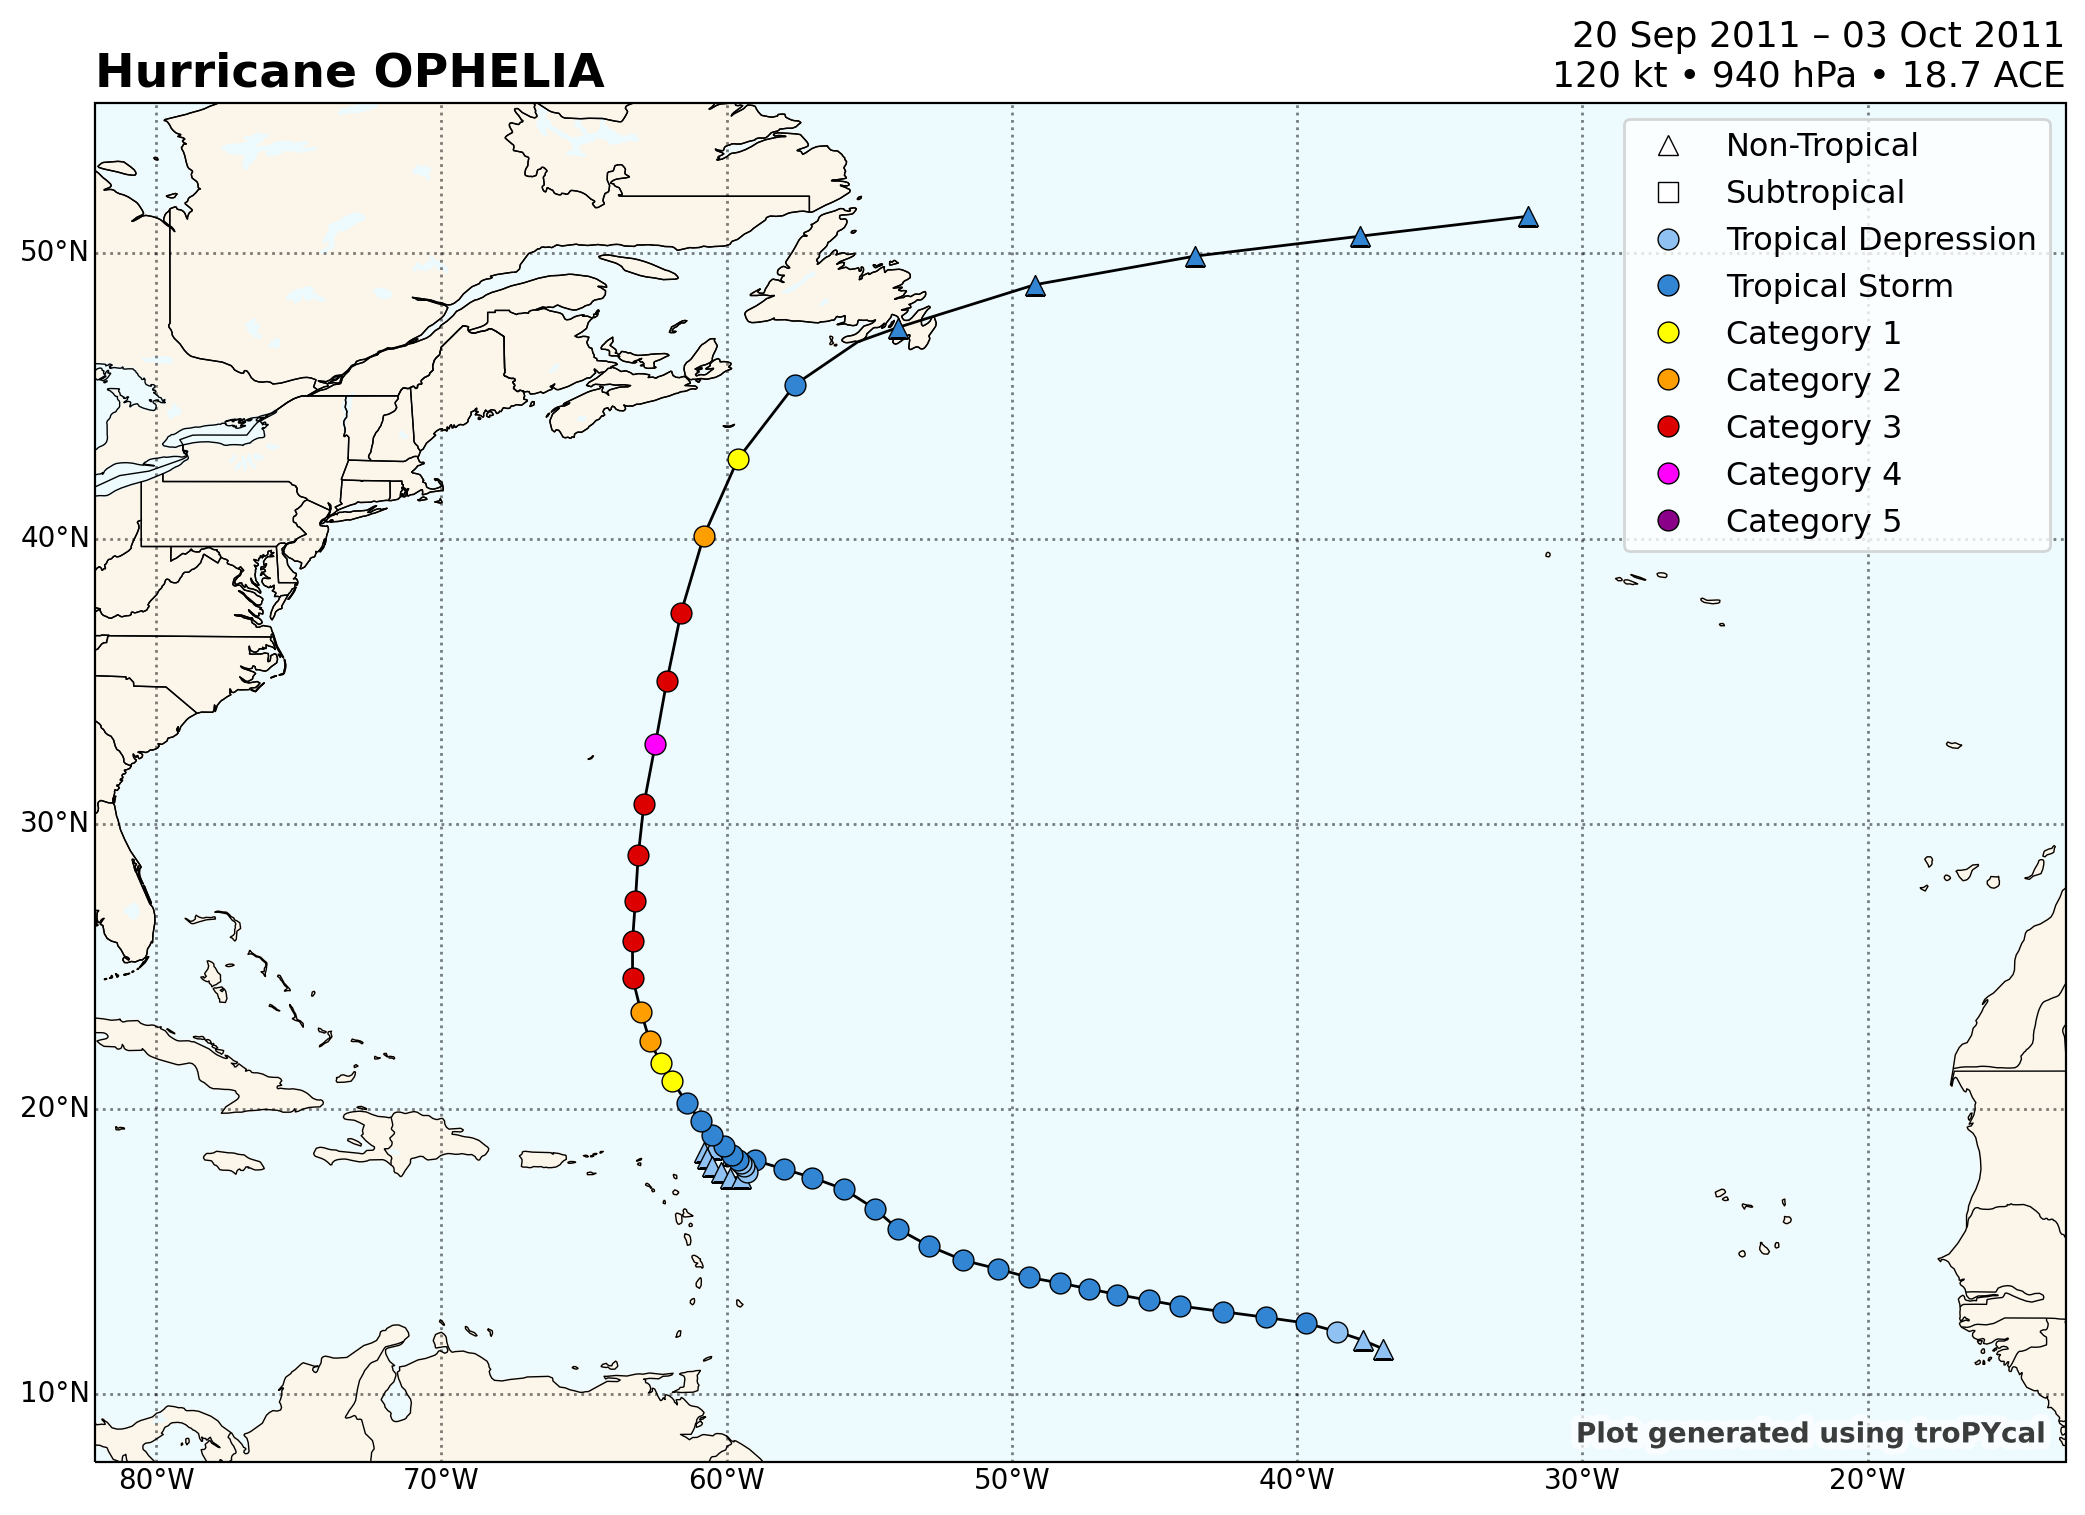

In [11]:
ophelia.plot()

In [13]:
df.sort_values(by='year',ascending=0)

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW,month,year
49104,AL122015,KATE,2015-11-13,1200,,EX,40.7,-45.4,45,987,...,0,0,0,0,0,0,0,0,11,2015
48881,AL062015,FRED,2015-08-30,1800,,TS,14.0,-20.7,55,998,...,30,30,10,20,0,0,0,0,8,2015
48873,AL052015,ERIKA,2015-08-27,1200,,TS,16.5,-62.2,45,1004,...,0,0,0,0,0,0,0,0,8,2015
48874,AL052015,ERIKA,2015-08-27,1800,,TS,16.6,-63.6,45,1006,...,0,0,0,0,0,0,0,0,8,2015
48875,AL052015,ERIKA,2015-08-28,0,,TS,17.2,-65.1,45,1006,...,0,0,0,0,0,0,0,0,8,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,AL051851,UNNAMED,1851-09-14,0,,TS,32.5,-73.5,50,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,9,1851
70,AL051851,UNNAMED,1851-09-14,600,,TS,32.5,-73.5,50,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,9,1851
71,AL051851,UNNAMED,1851-09-14,1200,,TS,32.5,-73.5,50,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,9,1851
72,AL051851,UNNAMED,1851-09-14,1800,,TS,32.5,-73.5,50,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,9,1851
